# Parameterization Experiments

In this notebook, we'll illustrate the process of learning a *parameterized* form for $\Omega$ from data with true labels. 

In [ ]:
using StatsBase
using Combinatorics
using Plots
using Optim

include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/read_data.jl")
include("jl/inference.jl")
include("jl/objectives.jl");

So, several things about this are reasonably neat. First, the value of $\alpha_k$ depends relatively smoothly on $k$. Perhaps more interesting is the fact that the small $k$ values of $\alpha$ are negative, suggesting that small groups of cosponsors actually tend to be heterogeneous. 

The strong dependence on size is worth querying further, however, and I don't fully trust these results. Considering that there's plenty of data, a better approach might be to do a similar method but with a different parameter in the dominator for each size, resulting in $2kmax$ parameters. This would allow us to check that this isn't just a model misbehavior in which the $\alpha_k$'s are actually attempting to do the work of $\alpha_0$. 

# Second Attempt

In [113]:
function plotα(dataset, kmax_)
    H, Z = read_hypergraph_data(dataset,kmax_)

    kmax = maximum(keys(H.E))
    kmin = minimum(keys(H.E))
    
    n = 1*length(H.D)
    α0 = vcat(1 .+ rand(kmax),  0.25.+0.5*rand(kmax))
    
    function ω(p, α)
        kmax = length(α) ÷ 2
        k = sum(p)
        return (p[1] / k)^α[k]  / n^(α[kmax+k]*k)
    end
    
    Ω = buildΩ(ω, α0, kmax);

    α = α0

    ℓ = maximum(k for k in keys(H.E)) # size of largest hyperedge

    C       = evalCuts(Z,H)
    V, μ, S = evalSums(Z,H,ℓ,true);

    order = vcat((kmax+1):(2*kmax), 1:kmax)
    
    res = 0
    for i = 1:20
        for h = 1:length(α0)
            j = order[h]
            function objective(a)
                alph = copy(α)
                alph[j] = a[1]
                obj = 0.0
                for p in keys(S)
                    Op = Ω(p; α=alph, mode="partition")
                    obj -= S[p]*Op
                    if p in keys(C)
                        obj += C[p]*log(Op)
                    end
                end
                return -obj # for minimization
            end
            res = optimize(objective, [α[j]], BFGS())
            α[j] = Optim.minimizer(res)[1]
        end
    end
    p1 = plot(kmin:kmax, α[kmin:kmax], seriestype = :scatter, label="", title = dataset)
    ylabel!("α")
    p2 = plot(kmin:kmax, α[(kmax+kmin):(2*kmax)], seriestype = :scatter, label="", color = "orange")
    ylabel!("β")
    ylims!((0,2))
    
    
    l = @layout [a ; b]
    println(Optim.minimum(res)[1])
    return plot(p1, p2, layout = l)
#     return(α)
end

plotα (generic function with 1 method)

2.830644756005904e6


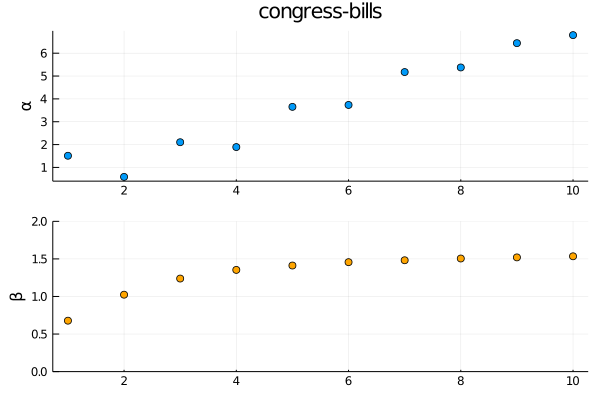

In [121]:
kmax = 10

# p1 = plotα("TrivagoClickout", kmax)
# p2 = plotα("walmart-trips",   kmax)
p3 = plotα("congress-bills",  kmax);
# p4 = plotα("contact-primary-school", kmax);
p3

# Conjecture

The other three plots are all behaving badly because they don't have edges of size 1, and in some cases size 2. In general, it looks like the implemented function will not perform well when we are missing edges of a given size, which makes sense. 

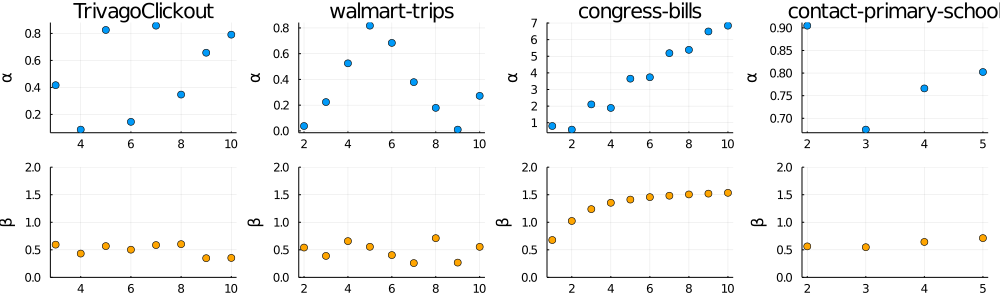

In [97]:
l = @layout [a b c d]
plot(p1, p2, p3, p4, layout = l, size = (1000, 300))